## Preparation

This section loads the necessary data.

In [1]:
# pip install pandas_datareader yfinance

In [2]:
#from pandas_datareader import data
#import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

Tickers of stocks:

In [3]:
# This table was downloaded from https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
# If needed, more companies can be taken from https://en.wikipedia.org/wiki/List_of_S%26P_400_companies
stocks = pd.read_csv('sp_500.csv')

In [4]:
stocks.head()

Symbol             Security SEC filings             GICS Sector  \
0    MMM           3M Company     reports             Industrials   
1    ABT  Abbott Laboratories     reports             Health Care   
2   ABBV          AbbVie Inc.     reports             Health Care   
3   ABMD              Abiomed     reports             Health Care   
4    ACN            Accenture     reports  Information Technology   

                GICS Sub-Industry    Headquarters Location Date first added  \
0        Industrial Conglomerates      St. Paul, Minnesota       09/08/1976   
1           Health Care Equipment  North Chicago, Illinois       31/03/1964   
2                 Pharmaceuticals  North Chicago, Illinois       31/12/2012   
3           Health Care Equipment   Danvers, Massachusetts       31/05/2018   
4  IT Consulting & Other Services          Dublin, Ireland       06/07/2011   

       CIK      Founded  
0    66740         1902  
1     1800         1888  
2  1551152  2013 (1888)  
3   815094         1981  
4  1467373         1989

Daily stock prices:

In [5]:
# The commented code downloads stock prices. They have been saved, so we load them. Run the commented code if you 
# need longer history.

# prices = data.DataReader(stocks.Symbol.values, 
#                        start='2015-1-1', 
#                        end='2015-12-31', 
#                        data_source='yahoo')['Adj Close']
# prices.to_csv('sp_500_prices.csv')

prices = pd.read_csv('sp_500_prices.csv')
prices = prices.set_index('Date')

In [6]:
prices.head()

MMM        ABT       ABBV       ABMD        ACN       ATVI  \
Date                                                                            
2015-01-02  136.070679  39.555874  49.226784  37.310001  78.392754  19.168922   
2015-01-05  133.001923  39.564690  48.300362  37.070000  77.069122  18.902290   
2015-01-06  131.583664  39.115395  48.061287  36.130001  76.513206  18.549955   
2015-01-07  132.537476  39.432537  50.003769  37.279999  78.119179  18.150005   
2015-01-08  135.714035  40.243046  50.526745  38.959999  79.310432  18.330935   

                 ADBE   AMD         AAP        AES  ...  DOW  FTV  FOXA  FOX  \
Date                                                ...                        
2015-01-02  72.339996  2.67  155.542526  10.716493  ...  NaN  NaN   NaN  NaN   
2015-01-05  71.980003  2.66  153.492310  10.411429  ...  NaN  NaN   NaN  NaN   
2015-01-06  70.529999  2.63  153.384399  10.176762  ...  NaN  NaN   NaN  NaN   
2015-01-07  71.110001  2.58  156.680481  10.192405  ...  NaN  NaN   NaN  NaN   
2015-01-08  72.919998  2.61  158.053787  10.348848  ...  NaN  NaN   NaN  NaN   

            HWM  IR  LW  LUMN  OTIS  UA  
Date                                     
2015-01-02  NaN NaN NaN   NaN   NaN NaN  
2015-01-05  NaN NaN NaN   NaN   NaN NaN  
2015-01-06  NaN NaN NaN   NaN   NaN NaN  
2015-01-07  NaN NaN NaN   NaN   NaN NaN  
2015-01-08  NaN NaN NaN   NaN   NaN NaN  

[5 rows x 505 columns]

## Objective

In this project, we:

* Cluster stocks into *k* groups using K-means.

* Provide a brief presentation of the results.

* Discuss potential next steps or improvements.

# Exploratory data analysis

Here we perform a pexploratory data analysis of the data provided. We first check some basic information of the 
data such as the number of samples, features, the presence of any missing values, and the overall distributions of 
the data. Then we inspect more detailed information of the data, such as the minimum and maximum returns per stock in 2015.

The goal is to gain some understanding of the dataset and make sure it is clean.

### stocks

In [7]:
stocks.head()

Symbol             Security SEC filings             GICS Sector  \
0    MMM           3M Company     reports             Industrials   
1    ABT  Abbott Laboratories     reports             Health Care   
2   ABBV          AbbVie Inc.     reports             Health Care   
3   ABMD              Abiomed     reports             Health Care   
4    ACN            Accenture     reports  Information Technology   

                GICS Sub-Industry    Headquarters Location Date first added  \
0        Industrial Conglomerates      St. Paul, Minnesota       09/08/1976   
1           Health Care Equipment  North Chicago, Illinois       31/03/1964   
2                 Pharmaceuticals  North Chicago, Illinois       31/12/2012   
3           Health Care Equipment   Danvers, Massachusetts       31/05/2018   
4  IT Consulting & Other Services          Dublin, Ireland       06/07/2011   

       CIK      Founded  
0    66740         1902  
1     1800         1888  
2  1551152  2013 (1888)  
3   815094         1981  
4  1467373         1989

In [8]:
stocks.shape

(505, 9)

We 505 stocks in total.

In [9]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 505 non-null    object
 1   Security               505 non-null    object
 2   SEC filings            505 non-null    object
 3   GICS Sector            505 non-null    object
 4   GICS Sub-Industry      505 non-null    object
 5   Headquarters Location  505 non-null    object
 6   Date first added       453 non-null    object
 7   CIK                    505 non-null    int64 
 8   Founded                505 non-null    object
dtypes: int64(1), object(8)
memory usage: 35.6+ KB


The goal of this project is to cluster related stocks using only their stock price data. The features 'GICS Sector' and 'GICS Sub-Industry' are particularly relevant, as it's reasonable to expect that stocks within the same or related industries tend to show similar price movements.

One idea: the clustring results based only on 'GICS Sector' and 'GICS Sub-Industry' could serve as baseline for evaluating the quality of the price-based clustring results. This could be a very strong baseline indeed.

In [10]:
# check GICS Sector and GICS Sub-Industry
stocks['GICS Sector'].value_counts()

GICS Sector
Industrials               74
Information Technology    74
Financials                65
Health Care               63
Consumer Discretionary    63
Consumer Staples          32
Real Estate               29
Utilities                 28
Materials                 28
Communication Services    26
Energy                    23
Name: count, dtype: int64

In [11]:
stocks['GICS Sector']

0                 Industrials
1                 Health Care
2                 Health Care
3                 Health Care
4      Information Technology
                ...          
500    Consumer Discretionary
501    Information Technology
502               Health Care
503                Financials
504               Health Care
Name: GICS Sector, Length: 505, dtype: object

In [12]:
# proportion of each sector among all companies
stocks['GICS Sector'].value_counts()/np.sum(stocks['GICS Sector'].value_counts())

GICS Sector
Industrials               0.146535
Information Technology    0.146535
Financials                0.128713
Health Care               0.124752
Consumer Discretionary    0.124752
Consumer Staples          0.063366
Real Estate               0.057426
Utilities                 0.055446
Materials                 0.055446
Communication Services    0.051485
Energy                    0.045545
Name: count, dtype: float64

We note that the number of companies in each GICS Sector is unbalanced. For example, only 4.5% compaines are in Energy sector while around 15% are in Industrials.

In [13]:
len(stocks['GICS Sector'].value_counts())

11

In [14]:
stocks['GICS Sub-Industry'].value_counts()

GICS Sub-Industry
Health Care Equipment    19
Semiconductors           15
Electric Utilities       13
Application Software     13
Industrial Machinery     13
                         ..
Diversified Chemicals     1
Reinsurance               1
Copper                    1
Consumer Electronics      1
Household Appliances      1
Name: count, Length: 124, dtype: int64

We have 11 GICS Sector in total and 124 GICS Sub-Industry. 

### Prices

In [15]:
prices.head()

MMM        ABT       ABBV       ABMD        ACN       ATVI  \
Date                                                                            
2015-01-02  136.070679  39.555874  49.226784  37.310001  78.392754  19.168922   
2015-01-05  133.001923  39.564690  48.300362  37.070000  77.069122  18.902290   
2015-01-06  131.583664  39.115395  48.061287  36.130001  76.513206  18.549955   
2015-01-07  132.537476  39.432537  50.003769  37.279999  78.119179  18.150005   
2015-01-08  135.714035  40.243046  50.526745  38.959999  79.310432  18.330935   

                 ADBE   AMD         AAP        AES  ...  DOW  FTV  FOXA  FOX  \
Date                                                ...                        
2015-01-02  72.339996  2.67  155.542526  10.716493  ...  NaN  NaN   NaN  NaN   
2015-01-05  71.980003  2.66  153.492310  10.411429  ...  NaN  NaN   NaN  NaN   
2015-01-06  70.529999  2.63  153.384399  10.176762  ...  NaN  NaN   NaN  NaN   
2015-01-07  71.110001  2.58  156.680481  10.192405  ...  NaN  NaN   NaN  NaN   
2015-01-08  72.919998  2.61  158.053787  10.348848  ...  NaN  NaN   NaN  NaN   

            HWM  IR  LW  LUMN  OTIS  UA  
Date                                     
2015-01-02  NaN NaN NaN   NaN   NaN NaN  
2015-01-05  NaN NaN NaN   NaN   NaN NaN  
2015-01-06  NaN NaN NaN   NaN   NaN NaN  
2015-01-07  NaN NaN NaN   NaN   NaN NaN  
2015-01-08  NaN NaN NaN   NaN   NaN NaN  

[5 rows x 505 columns]

In [16]:
prices.shape

(252, 505)

We have in total 505 stocks and 252 dates. We also note that there are missing data in entries.

In [17]:
# check columns containing only missing data
prices.columns[prices.isna().all()]

Index(['BRK.B', 'BF.B', 'CARR', 'CTVA', 'DOW', 'FTV', 'FOXA', 'FOX', 'HWM',
       'IR', 'LW', 'LUMN', 'OTIS', 'UA'],
      dtype='object')

In [18]:
# drop columns containing only missing data
prices = prices.dropna(axis=1, how='all')

In [19]:
# check shape is correct
prices.shape

(252, 491)

In [20]:
# check columns with at least one missing data
prices.columns[prices.isna().any()]

Index(['ETSY', 'HPE', 'KHC', 'PYPL', 'WRK'], dtype='object')

In [21]:
# check number of missing data in columns with at least one missing data
prices[prices.columns[prices.isna().any()]].isna().sum()

ETSY     71
HPE     200
KHC     126
PYPL    126
WRK     119
dtype: int64

In [22]:
# delete columns with at least one missing data
prices = prices.dropna(axis=1, how='any')

In [23]:
# check the shape again
prices.shape

(252, 486)

We removed all stocks with missing data. Now we have a clean dataset with no missing data.

In [24]:
# compute daily return
prices_change = prices.pct_change()

In [25]:
prices_change.head()

MMM       ABT      ABBV      ABMD       ACN      ATVI  \
Date                                                                     
2015-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2015-01-05 -0.022553  0.000223 -0.018819 -0.006433 -0.016885 -0.013910   
2015-01-06 -0.010663 -0.011356 -0.004950 -0.025357 -0.007213 -0.018640   
2015-01-07  0.007249  0.008108  0.040417  0.031829  0.020989 -0.021561   
2015-01-08  0.023967  0.020554  0.010459  0.045064  0.015249  0.009969   

                ADBE       AMD       AAP       AES  ...      WLTW      WYNN  \
Date                                                ...                       
2015-01-02       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2015-01-05 -0.004976 -0.003745 -0.013181 -0.028467  ... -0.007183 -0.017020   
2015-01-06 -0.020145 -0.011278 -0.000703 -0.022539  ... -0.004974 -0.021331   
2015-01-07  0.008223 -0.019011  0.021489  0.001537  ...  0.014315  0.029368   
2015-01-08  0.025453  0.011628  0.008765  0.015349  ...  0.011425  0.012031   

                 XEL      XLNX       XYL       YUM      ZBRA       ZBH  \
Date                                                                     
2015-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2015-01-05 -0.011351 -0.018349 -0.062238 -0.020318 -0.014077  0.037303   
2015-01-06  0.005320 -0.014486 -0.005881 -0.012274 -0.007205 -0.008476   
2015-01-07  0.008635  0.000474  0.007887  0.033138  0.025465  0.024870   
2015-01-08  0.011599  0.022275  0.007546  0.017420  0.021359  0.010617   

                ZION       ZTS  
Date                            
2015-01-02       NaN       NaN  
2015-01-05 -0.037469 -0.006003  
2015-01-06 -0.038193 -0.009756  
2015-01-07  0.009546  0.020643  
2015-01-08  0.013994  0.015399  

[5 rows x 486 columns]

In [26]:
# we transpose the data matrix
prices_change = prices_change.T

In [27]:
prices_change = prices_change.drop(['2015-01-02'], axis=1) # drop the first day (no returns)

In [28]:
prices_change

Date  2015-01-05  2015-01-06  2015-01-07  2015-01-08  2015-01-09  2015-01-12  \
MMM    -0.022553   -0.010663    0.007249    0.023967   -0.012283   -0.005445   
ABT     0.000223   -0.011356    0.008108    0.020554   -0.010508    0.008407   
ABBV   -0.018819   -0.004950    0.040417    0.010459   -0.027355   -0.000304   
ABMD   -0.006433   -0.025357    0.031829    0.045064   -0.014117    0.003905   
ACN    -0.016885   -0.007213    0.020989    0.015249   -0.001113   -0.003007   
...          ...         ...         ...         ...         ...         ...   
YUM    -0.020318   -0.012274    0.033138    0.017420   -0.001767   -0.007487   
ZBRA   -0.014077   -0.007205    0.025465    0.021359    0.014613    0.001490   
ZBH     0.037303   -0.008476    0.024870    0.010617   -0.014424    0.002369   
ZION   -0.037469   -0.038193    0.009546    0.013994   -0.027975   -0.015349   
ZTS    -0.006003   -0.009756    0.020643    0.015399    0.001584   -0.018757   

Date  2015-01-13  2015-01-14  2015-01-15  2015-01-16  ...  2015-12-17  \
MMM    -0.000747   -0.004856   -0.001126    0.014656  ...   -0.007336   
ABT    -0.016101   -0.007398   -0.007453    0.012287  ...   -0.017155   
ABBV   -0.028804    0.004890   -0.012716    0.026236  ...   -0.021690   
ABMD    0.006483   -0.014429   -0.029804    0.021827  ...   -0.010053   
ACN     0.003575   -0.011689   -0.006871    0.008166  ...   -0.053355   
...          ...         ...         ...         ...  ...         ...   
YUM    -0.004115    0.001524   -0.011894    0.013716  ...   -0.018221   
ZBRA    0.023308   -0.015871    0.000615    0.020054  ...   -0.053419   
ZBH     0.002194   -0.013221   -0.018774    0.017568  ...   -0.011969   
ZION   -0.017147   -0.017050   -0.012102    0.011842  ...   -0.015952   
ZTS    -0.014049    0.005139   -0.002092    0.029809  ...   -0.007645   

Date  2015-12-18  2015-12-21  2015-12-22  2015-12-23  2015-12-24  2015-12-28  \
MMM    -0.012966    0.003811    0.010103    0.014701    0.000198    0.000198   
ABT    -0.034467    0.007780    0.009991    0.013939    0.000000   -0.001552   
ABBV   -0.011352    0.008253    0.024733    0.017190   -0.002048    0.004961   
ABMD    0.022528    0.008219   -0.007246    0.006501    0.023569   -0.015056   
ACN    -0.012880    0.010399    0.007476    0.006361   -0.001820   -0.001439   
...          ...         ...         ...         ...         ...         ...   
YUM    -0.004986    0.021715   -0.005450    0.015343   -0.001619   -0.002162   
ZBRA   -0.030700    0.049526    0.030473    0.019523   -0.002112   -0.011006   
ZBH    -0.017377    0.012833    0.014966    0.010223    0.001362   -0.006413   
ZION   -0.037824    0.002246    0.014569    0.018778    0.003975   -0.005039   
ZTS    -0.002782    0.015880    0.008027    0.005448    0.003127   -0.004779   

Date  2015-12-29  2015-12-30  2015-12-31  
MMM     0.011044   -0.006410   -0.008360  
ABT     0.017544   -0.012003   -0.007952  
ABBV    0.011915    0.005887   -0.009365  
ABMD    0.043385   -0.007648   -0.019974  
ACN     0.011914    0.005127   -0.012847  
...          ...         ...         ...  
YUM     0.005417   -0.005792   -0.010297  
ZBRA    0.002568   -0.011669    0.002880  
ZBH     0.007253   -0.002919    0.001171  
ZION    0.006150   -0.012226   -0.006188  
ZTS     0.008977   -0.001448   -0.007045  

[486 rows x 251 columns]

In [29]:
prices_change.columns = pd.to_datetime(prices_change.columns, format='%Y-%m-%d').date

In [30]:
prices_change.head()

2015-01-05  2015-01-06  2015-01-07  2015-01-08  2015-01-09  2015-01-12  \
MMM    -0.022553   -0.010663    0.007249    0.023967   -0.012283   -0.005445   
ABT     0.000223   -0.011356    0.008108    0.020554   -0.010508    0.008407   
ABBV   -0.018819   -0.004950    0.040417    0.010459   -0.027355   -0.000304   
ABMD   -0.006433   -0.025357    0.031829    0.045064   -0.014117    0.003905   
ACN    -0.016885   -0.007213    0.020989    0.015249   -0.001113   -0.003007   

      2015-01-13  2015-01-14  2015-01-15  2015-01-16  ...  2015-12-17  \
MMM    -0.000747   -0.004856   -0.001126    0.014656  ...   -0.007336   
ABT    -0.016101   -0.007398   -0.007453    0.012287  ...   -0.017155   
ABBV   -0.028804    0.004890   -0.012716    0.026236  ...   -0.021690   
ABMD    0.006483   -0.014429   -0.029804    0.021827  ...   -0.010053   
ACN     0.003575   -0.011689   -0.006871    0.008166  ...   -0.053355   

      2015-12-18  2015-12-21  2015-12-22  2015-12-23  2015-12-24  2015-12-28  \
MMM    -0.012966    0.003811    0.010103    0.014701    0.000198    0.000198   
ABT    -0.034467    0.007780    0.009991    0.013939    0.000000   -0.001552   
ABBV   -0.011352    0.008253    0.024733    0.017190   -0.002048    0.004961   
ABMD    0.022528    0.008219   -0.007246    0.006501    0.023569   -0.015056   
ACN    -0.012880    0.010399    0.007476    0.006361   -0.001820   -0.001439   

      2015-12-29  2015-12-30  2015-12-31  
MMM     0.011044   -0.006410   -0.008360  
ABT     0.017544   -0.012003   -0.007952  
ABBV    0.011915    0.005887   -0.009365  
ABMD    0.043385   -0.007648   -0.019974  
ACN     0.011914    0.005127   -0.012847  

[5 rows x 251 columns]

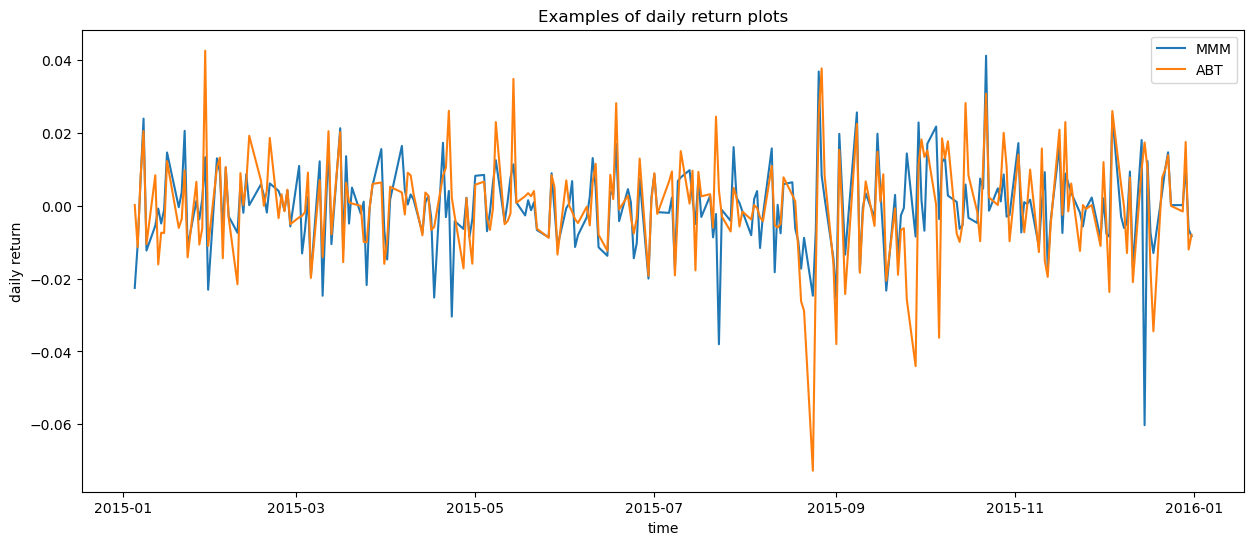

In [31]:
# examples of daily return plots
plt.figure(figsize=(15,6))
plt.plot(prices_change.columns, prices_change.iloc[0,:].values, label='MMM')
plt.plot(prices_change.columns, prices_change.iloc[1,:].values, label='ABT')
plt.title('Examples of daily return plots')
plt.xlabel('time')
plt.ylabel('daily return')
plt.legend()
plt.show()

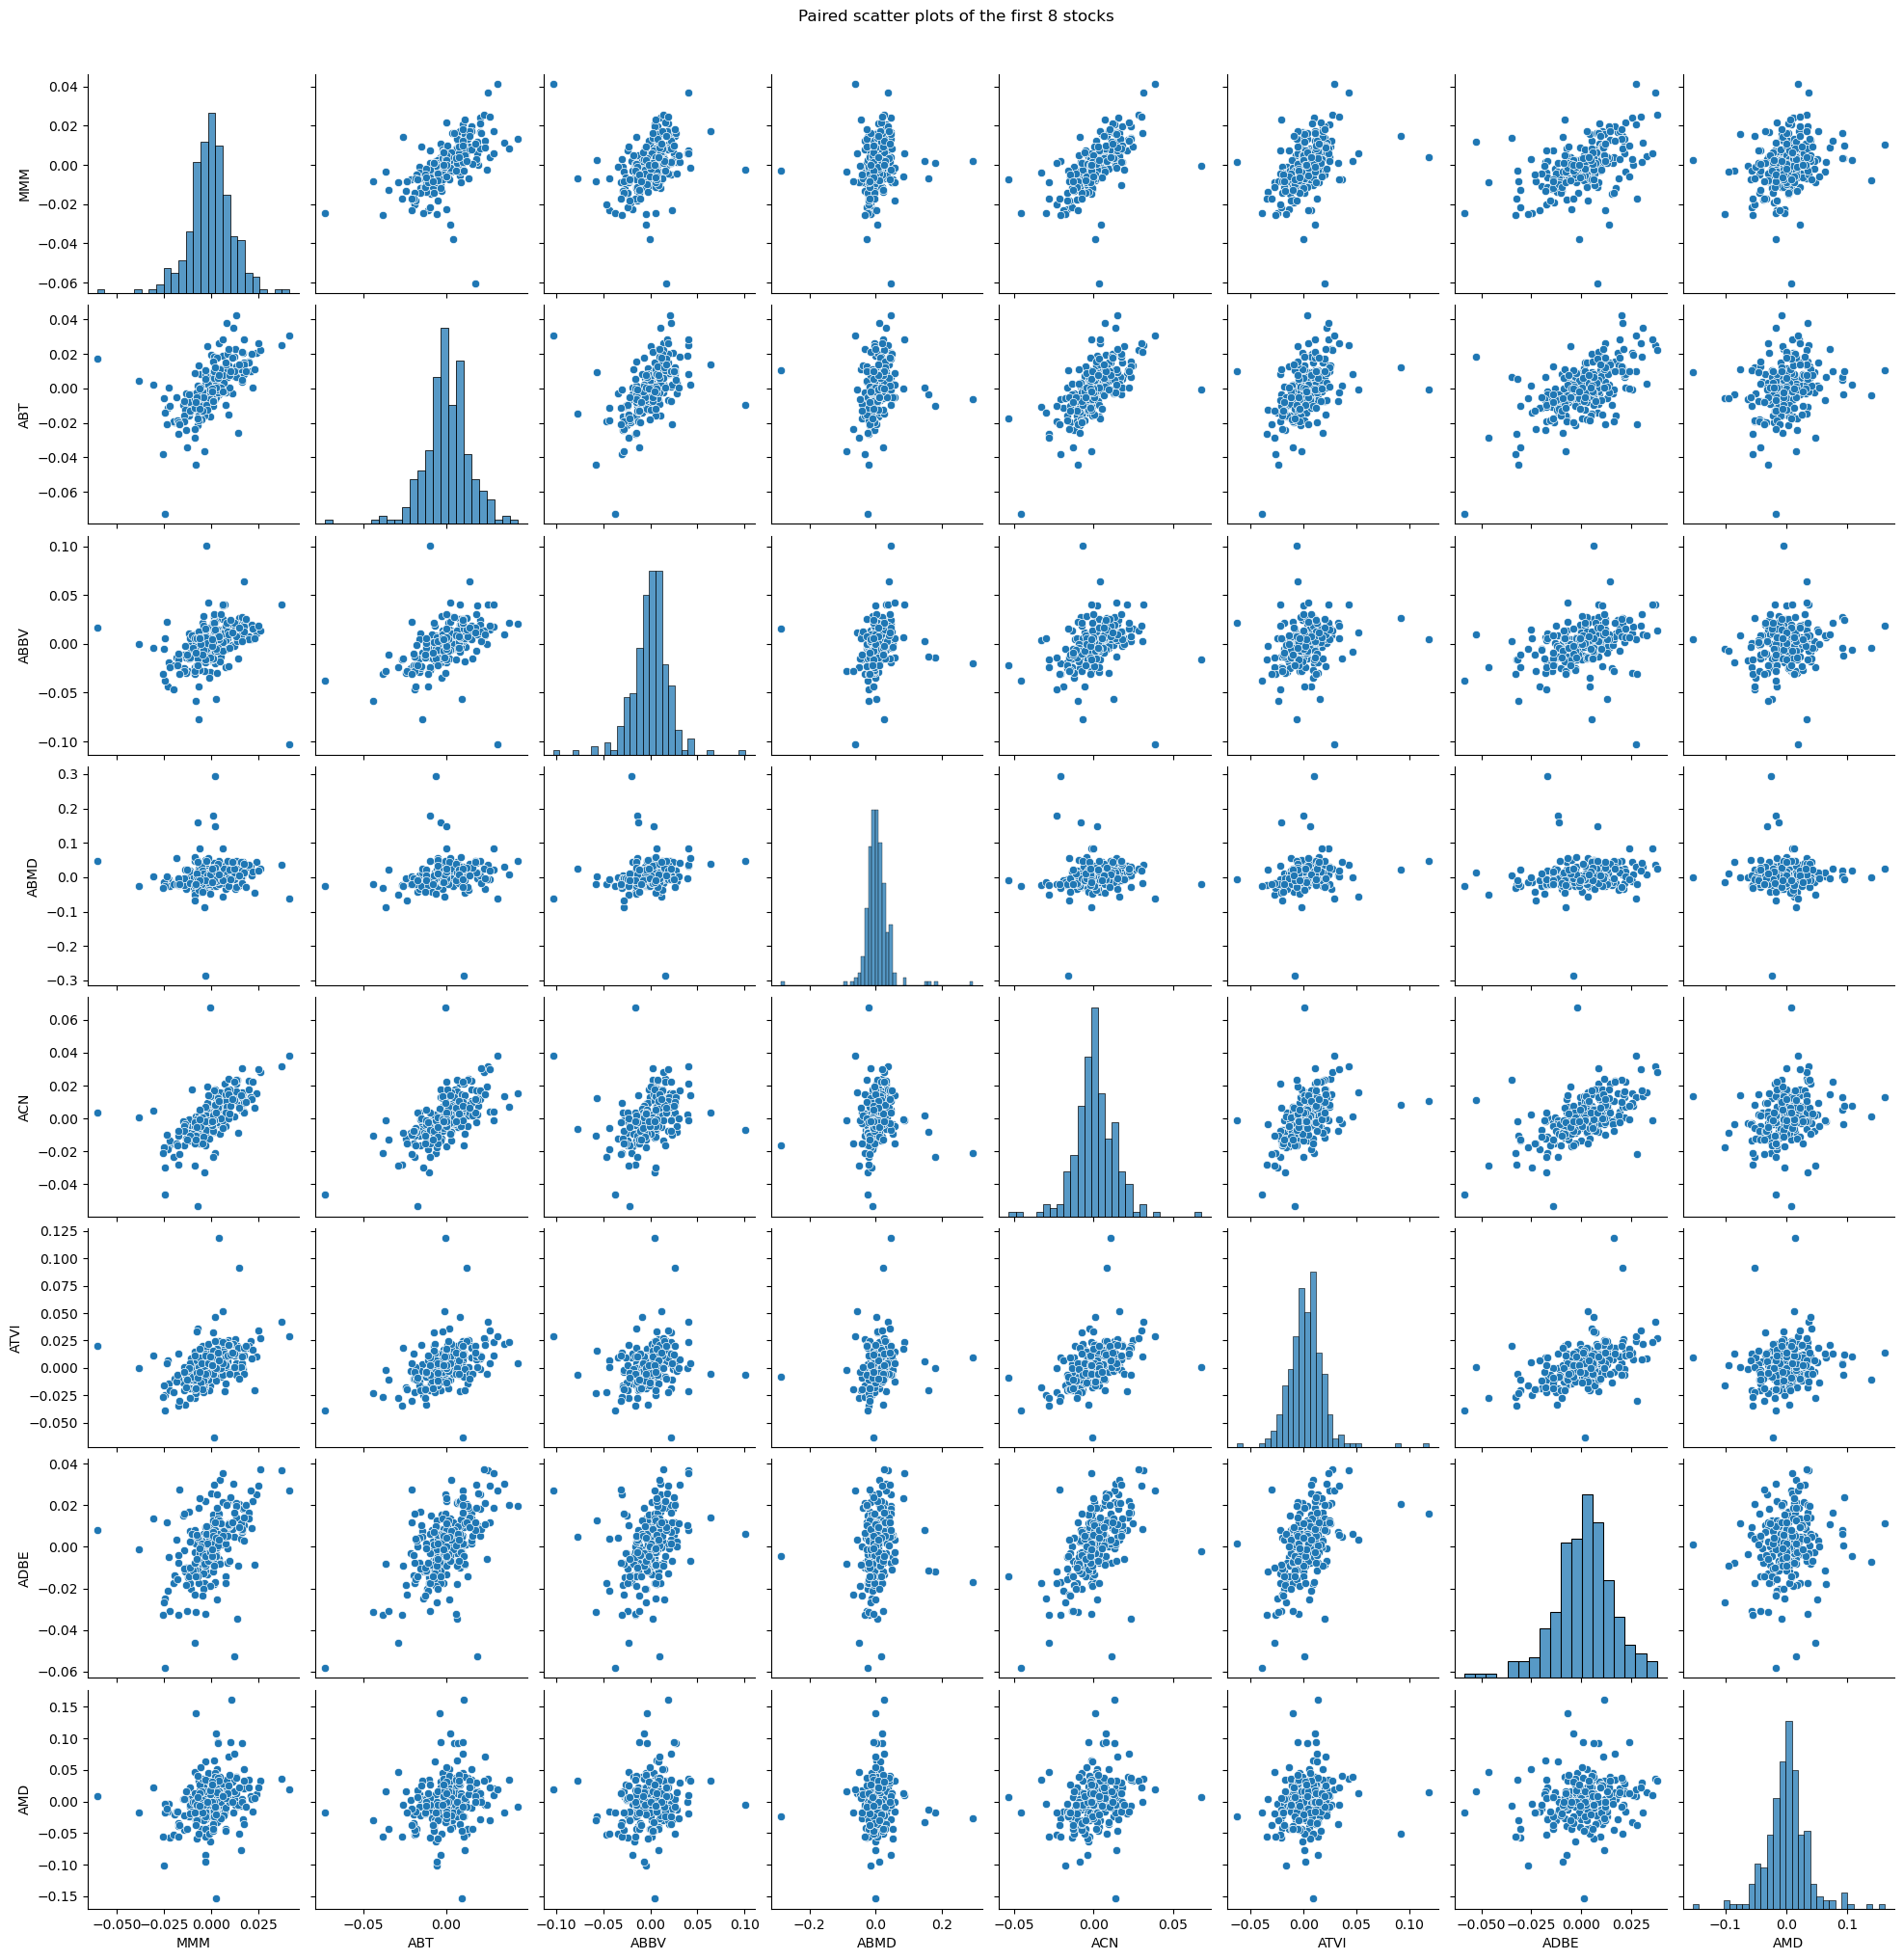

In [32]:
# paired plots of the first 8 stocks in the data
g = sns.pairplot(prices_change.T.iloc[:, :8])
g.fig.suptitle('Paired scatter plots of the first 8 stocks', y=1.02)
plt.show()

There are a few observations from the paired plots:
1. Some stocks exhibit stronger correlations than others. For example, MMM and ABT appear to be highly positively correlated, whereas stocks like AMD and ABT show little to no correlation.
2. The distributions of daily returns are heavy-tailed, with visible outliers in the scatter plots.
3. Due to the presence of outliers and heavy tails, Spearman’s rank correlation may be more appropriate than Pearson’s correlation, as it is more robust to such irregularities.

In [33]:
# compute pearson and spearman corr matrix
pearson_corr_matrix = prices_change.T.iloc[:,:8].corr(method='pearson')
spearman_corr_matrix = prices_change.T.iloc[:,:8].corr(method='spearman')

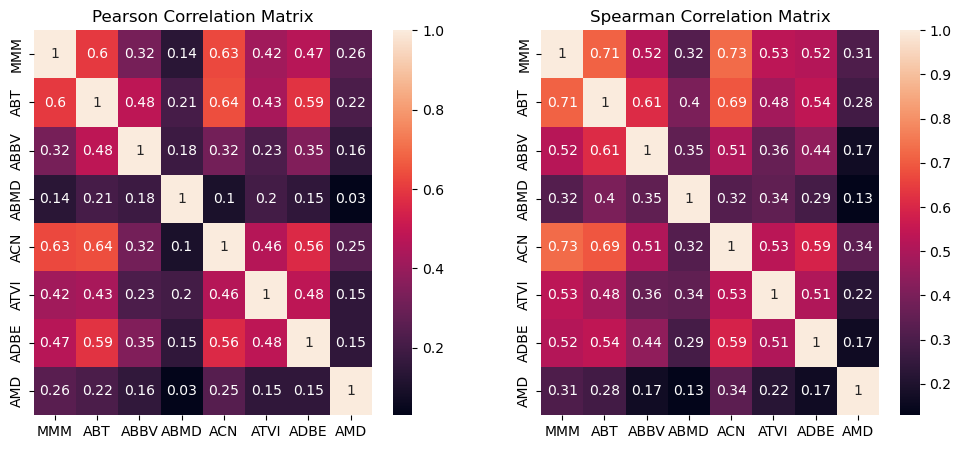

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(pearson_corr_matrix, annot=True, ax=axes[0])
sns.heatmap(spearman_corr_matrix, annot=True, ax=axes[1])
axes[0].set_title('Pearson Correlation Matrix')
axes[1].set_title('Spearman Correlation Matrix')
plt.show()

The above two correlation matrixs are computed using Peason's correlation and Spearman's correlation, respectively. We can see the two correlation coefficients present similar results: when a pair has high value of pearson's correlation, it also tends to have high value of Spearman's correlation. 

However they are not identical. For example, Pearson's correlation shows that ACN-ABT are more corrleated than ACN-MMM, while Spearman's correlation shows vice verce. This might be caused by outliers according to the paired scatter plots.

In the followling, we will consider only Spearman's correlation since it does not assume data distribution and is more robust to outliers.

We consider the distributions and correlations of the first 8 stocks as examples. As we have in total 486 stocks, it is impractical to inspect each stock's price return individually.

 Instead, we proceed by analyzing summary statistics for each stock, such as overall return in 2015, as well as the maximum and minimum daily returns during that year.

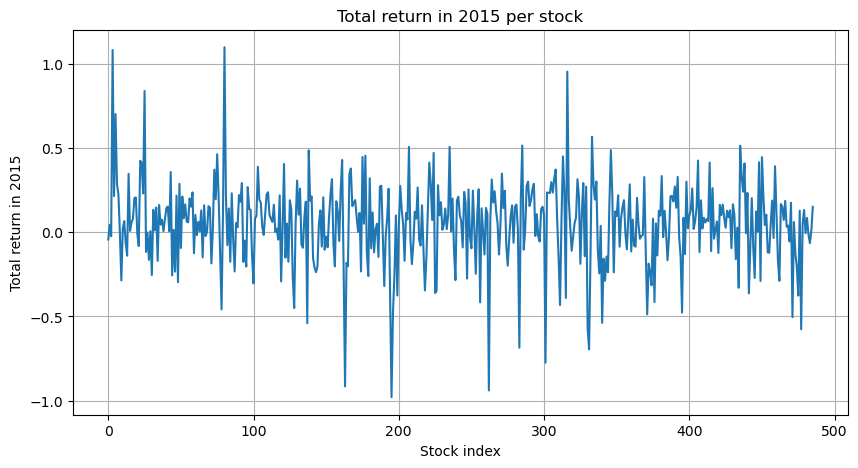

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(prices_change.sum(axis=1).values)
plt.xlabel('Stock index')
plt.ylabel('Total return in 2015')
plt.title('Total return in 2015 per stock')
plt.grid(True)
plt.show()

Most stocks have total return in 2015 between -5% and 5%.

In [36]:
print('proportion of compaines with negative returns in 2015: ', np.sum(prices_change.sum(axis=1).values < 0) / prices_change.shape[0])
print('proportion of compaines with positive returns in 2015: ', np.sum(prices_change.sum(axis=1).values > 0) / prices_change.shape[0])

proportion of compaines with negative returns in 2015:  0.3559670781893004
proportion of compaines with positive returns in 2015:  0.6440329218106996


65% compaines have positive returns and 35% have negative returns.

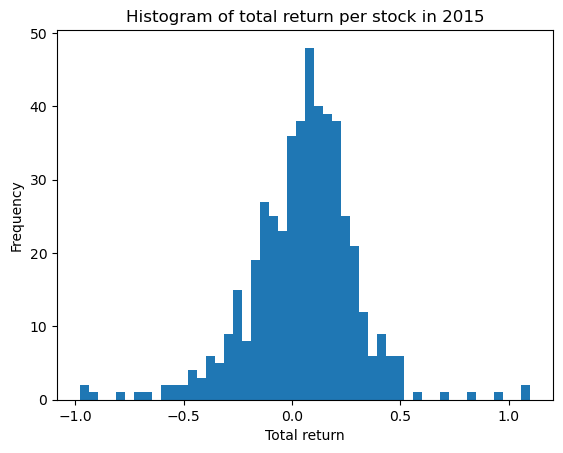

In [37]:
# distribution of total return
plt.hist(prices_change.sum(axis=1).values, bins=50)
plt.title('Histogram of total return per stock in 2015')
plt.xlabel('Total return')
plt.ylabel('Frequency')
plt.show()

The distribution of total return is asymmetric, with heavy tails.

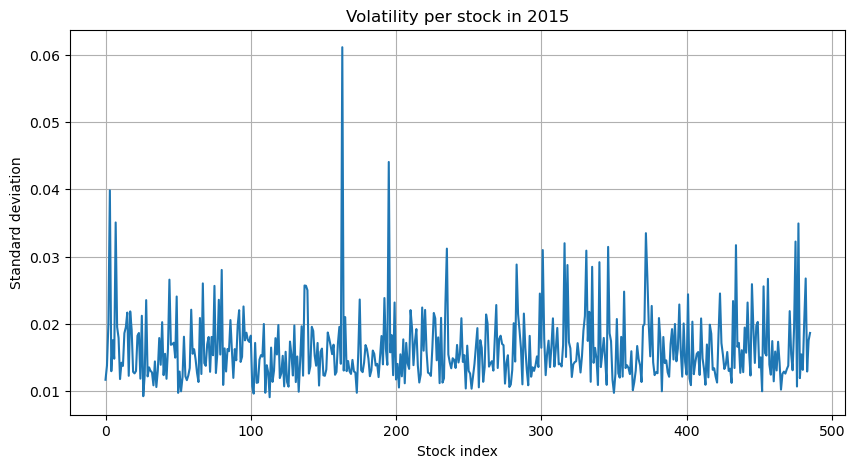

In [38]:
# check volatility of all stocks
plt.figure(figsize=(10, 5))
plt.plot(prices_change.std(axis=1).values)
plt.xlabel('Stock index')
plt.ylabel('Standard deviation')
plt.title('Volatility per stock in 2015')
plt.grid(True)
plt.show()

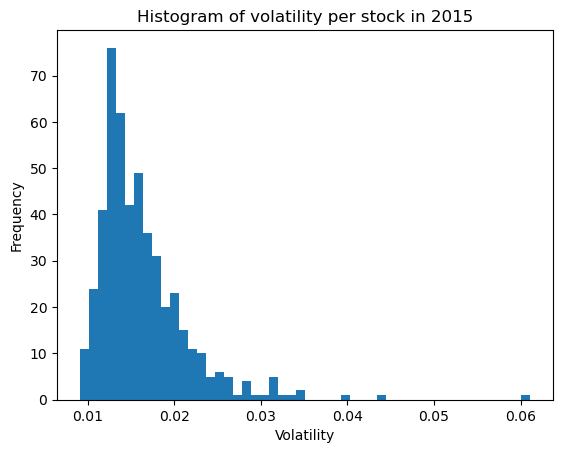

In [39]:
plt.hist(prices_change.std(axis=1).values, bins=50)
plt.title('Histogram of volatility per stock in 2015')
plt.xlabel('Volatility')
plt.ylabel('Frequency')
plt.show()

The distribution of volatility is chi-sqaure shape distributed (shift right) with heavy right tail.

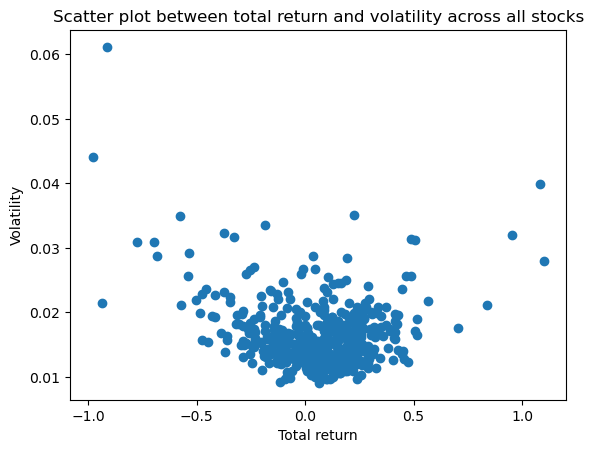

In [40]:
# check the relationship between total return and volatility
plt.scatter(prices_change.sum(axis=1).values, prices_change.std(axis=1).values)
plt.xlabel('Total return')
plt.ylabel('Volatility')
plt.title('Scatter plot between total return and volatility across all stocks')
plt.show()

The above scatter plot shows that the stock with large or small total return tends to have large volatility. 

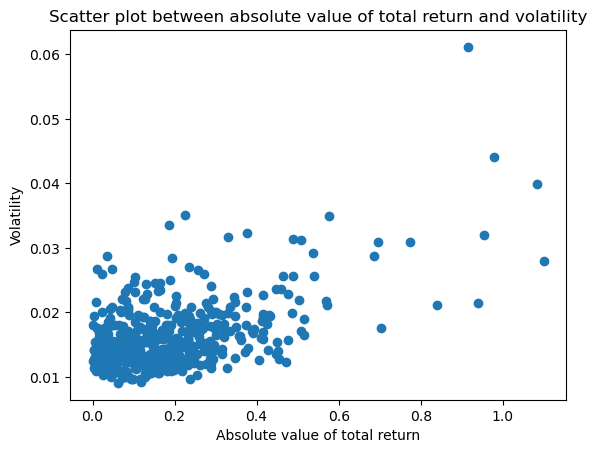

In [41]:
plt.scatter(np.abs(prices_change.sum(axis=1).values), prices_change.std(axis=1).values)
plt.xlabel('Absolute value of total return')
plt.ylabel('Volatility')
plt.title('Scatter plot between absolute value of total return and volatility')
plt.show()

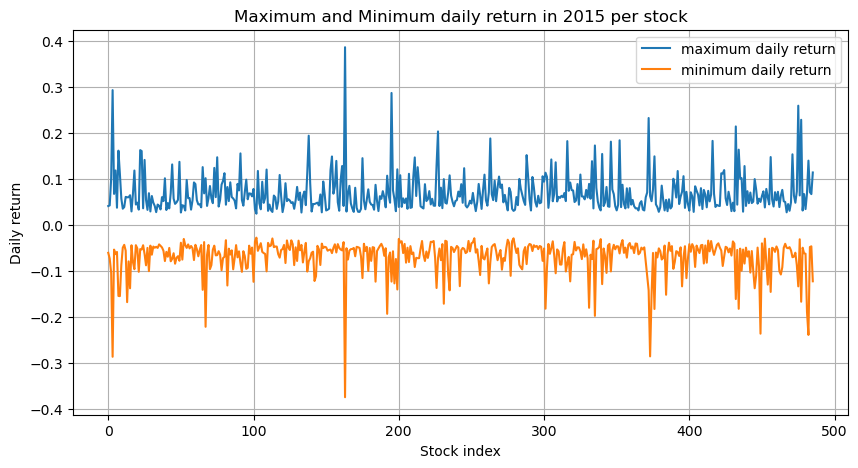

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(prices_change.max(axis=1).values, label='maximum daily return')
plt.plot(prices_change.min(axis=1).values, label='minimum daily return')
plt.xlabel('Stock index')
plt.ylabel('Daily return')
plt.title('Maximum and Minimum daily return in 2015 per stock')
plt.legend()
plt.grid(True)
plt.show()

1. Most stocks have maximum daily return lower than 20% and minimum daily return larger than -20% in 2015. 
2. The plots of maximum and minimum daily return show certain symmetry, i.e. a stock with higher maximum daily return tends to have lower minimum daily return.

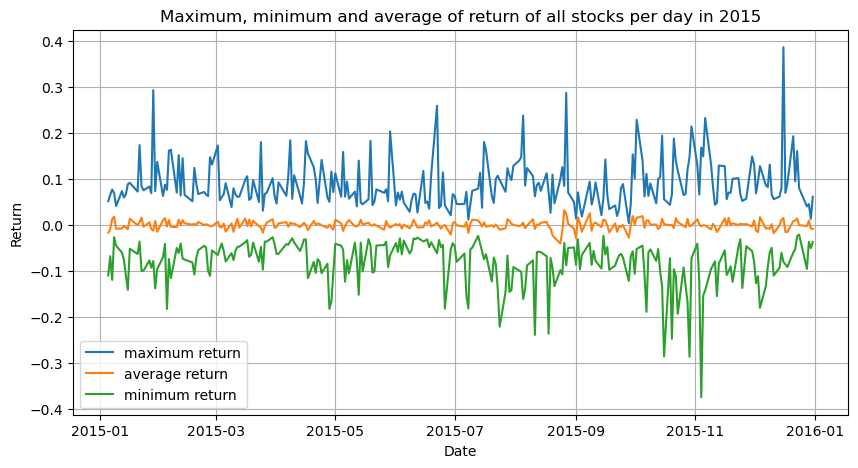

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(prices_change.max(axis=0), label='maximum return')
plt.plot(prices_change.mean(axis=0), label='average return')
plt.plot(prices_change.min(axis=0), label='minimum return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Maximum, minimum and average of return of all stocks per day in 2015')
plt.legend()
plt.grid(True)
plt.show()

1. the average return across all stocks per day is close to 0.
2. for most days, the maximum returns are smaller than 20% and the minimum returns are larger than -20%.

# Baseline model

As a baseline model, we assign stocks with the same 'GICS Sector' feature into the same cluster.

In [44]:
prices_change.index.name = 'Symbol'

In [45]:
stocks = stocks.set_index('Symbol')

In [46]:
# for our purposes, we merge stocks and prices
complete_data = prices_change.join(stocks)

In [47]:
complete_data.head()

2015-01-05  2015-01-06  2015-01-07  2015-01-08  2015-01-09  \
Symbol                                                               
MMM      -0.022553   -0.010663    0.007249    0.023967   -0.012283   
ABT       0.000223   -0.011356    0.008108    0.020554   -0.010508   
ABBV     -0.018819   -0.004950    0.040417    0.010459   -0.027355   
ABMD     -0.006433   -0.025357    0.031829    0.045064   -0.014117   
ACN      -0.016885   -0.007213    0.020989    0.015249   -0.001113   

        2015-01-12  2015-01-13  2015-01-14  2015-01-15  2015-01-16  ...  \
Symbol                                                              ...   
MMM      -0.005445   -0.000747   -0.004856   -0.001126    0.014656  ...   
ABT       0.008407   -0.016101   -0.007398   -0.007453    0.012287  ...   
ABBV     -0.000304   -0.028804    0.004890   -0.012716    0.026236  ...   
ABMD      0.003905    0.006483   -0.014429   -0.029804    0.021827  ...   
ACN      -0.003007    0.003575   -0.011689   -0.006871    0.008166  ...   

        2015-12-30  2015-12-31             Security  SEC filings  \
Symbol                                                             
MMM      -0.006410   -0.008360           3M Company      reports   
ABT      -0.012003   -0.007952  Abbott Laboratories      reports   
ABBV      0.005887   -0.009365          AbbVie Inc.      reports   
ABMD     -0.007648   -0.019974              Abiomed      reports   
ACN       0.005127   -0.012847            Accenture      reports   

                   GICS Sector               GICS Sub-Industry  \
Symbol                                                           
MMM                Industrials        Industrial Conglomerates   
ABT                Health Care           Health Care Equipment   
ABBV               Health Care                 Pharmaceuticals   
ABMD               Health Care           Health Care Equipment   
ACN     Information Technology  IT Consulting & Other Services   

          Headquarters Location  Date first added      CIK      Founded  
Symbol                                                                   
MMM         St. Paul, Minnesota        09/08/1976    66740         1902  
ABT     North Chicago, Illinois        31/03/1964     1800         1888  
ABBV    North Chicago, Illinois        31/12/2012  1551152  2013 (1888)  
ABMD     Danvers, Massachusetts        31/05/2018   815094         1981  
ACN             Dublin, Ireland        06/07/2011  1467373         1989  

[5 rows x 259 columns]

In [48]:
# check the shape
complete_data.shape

(486, 259)

In [49]:
# compute correlation matrix
num_dates = 251
spearman_corr_matrix = complete_data.sort_values(by='GICS Sector').iloc[:,:num_dates].T.corr(method='spearman').values

[]

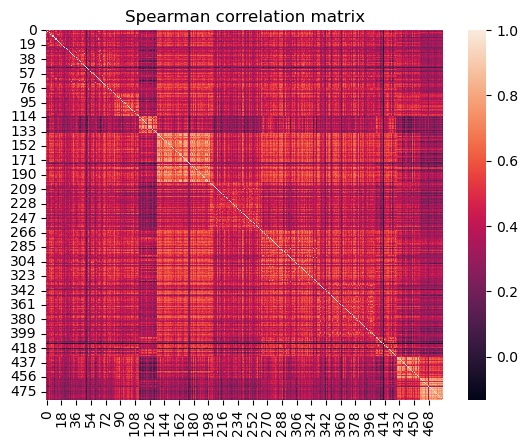

In [50]:
sns.heatmap(spearman_corr_matrix)
plt.title('Spearman correlation matrix')
plt.plot()

We can see several bright blocks on the diagnoal, indicating stocks in these blocks having higher correlations than average. 

In [51]:
def clustering_scores(corr_matrix, num_clusters):
    # corr_matrix: correlation matrix ordered such that correlation between stocks in the same cluster are in the same block lie on the diagnol. 
    # num_clusters: number of samples within each cluster
    corr_within_group = []
    last_num = 0
    for num in num_clusters:
        corr_within_group.append(np.mean(corr_matrix[last_num:last_num+num, last_num:last_num+num]))
        last_num += num
    corr_within_group = np.array(corr_within_group)
    weighted_corr = np.sum((corr_within_group * num_clusters)/ np.sum(num_clusters))
    
    return corr_within_group, weighted_corr

In [52]:
num_clusters = complete_data['GICS Sector'].value_counts().sort_index().values
baseline_group_corr, baseline_score = clustering_scores(spearman_corr_matrix, num_clusters)

In [53]:
# correlation within each GICS sector
print(baseline_group_corr)

[0.43962918 0.44731722 0.56236333 0.60108509 0.66260468 0.49587075
 0.51630568 0.48688256 0.48429282 0.65876451 0.72651407]


In [54]:
# number of stocks in each GICS sector
print(num_clusters)

[23 61 29 23 64 63 69 72 25 29 28]


In [55]:
# weighted average correlation across each GICS sector (with weight proportional to sample size in each sector)
print(baseline_score)

0.5420008107757865


In [56]:
# average correlation across all stocks without clustering
mean_corr = np.mean(spearman_corr_matrix)

In [57]:
print('average correlation across all stocks without clustering is: ', mean_corr)

average correlation across all stocks without clustering is:  0.41711750020274063


The average spearman correlation accross all stocks without clustering is below 0.42. The baseline model clusters stocks using GICS Sector feature directly. Results show that within each cluster given by the baseline model, the average Spearman correlation is larger than 0.42, with Communication Services Sector having smallest correlation 0.4396 and Utilities Sector having largest correlation 0.7265.

The weighted average Spearman correlation after clustering by baseline model is around 0.54. 
This suggests the baseline model is a very strong reference. This is not surpursing, however, as we would expect stocks in the same or related sector show similar price movements.

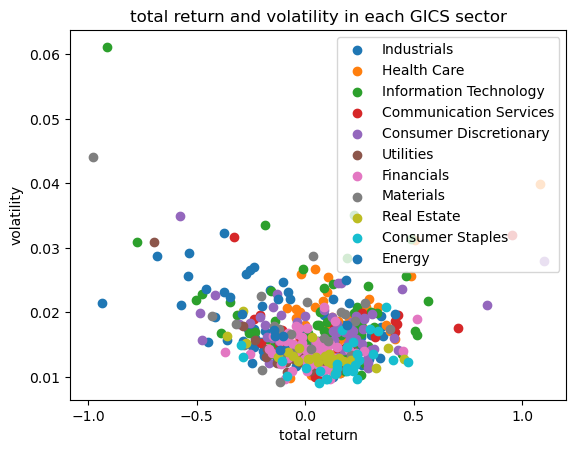

In [58]:
# it would be interesting to check the mean and std of each stocks in different GICS sector
for sector in complete_data['GICS Sector'].unique():
    x = complete_data[complete_data['GICS Sector'] == sector].iloc[:,:num_dates].sum(axis=1)
    y = complete_data[complete_data['GICS Sector'] == sector].iloc[:,:num_dates].std(axis=1)
    plt.scatter(x,y, label=sector)
plt.xlabel('total return')
plt.ylabel('volatility')
plt.title('total return and volatility in each GICS sector')
plt.legend()
plt.show()

From the above plot, we can not see clear difference of stocks in different GICS sectors in terms of total return and volatility. Below we check the mean of total return and volatility of each sector. 

In [59]:
complete_data['total return'] = complete_data.iloc[:,:num_dates].sum(axis=1)
complete_data['volatility'] = complete_data.iloc[:,:num_dates].std(axis=1)

In [60]:
complete_data.groupby(by='GICS Sector')['total return'].mean()

GICS Sector
Communication Services    0.143950
Consumer Discretionary    0.100825
Consumer Staples          0.153709
Energy                   -0.211929
Financials                0.040718
Health Care               0.143572
Industrials              -0.008645
Information Technology    0.064847
Materials                -0.038694
Real Estate               0.070437
Utilities                -0.041603
Name: total return, dtype: float64

The total return in each GICS sector could be very different in 2015. For example, Communication Services has total return 0.14 while Energy has -0.21. However, we also note there are different sectors sharing similar total return, e.g. Communication Services and Health Care.

In [61]:
complete_data.groupby(by='GICS Sector')['volatility'].mean()

GICS Sector
Communication Services    0.017284
Consumer Discretionary    0.017422
Consumer Staples          0.012673
Energy                    0.022217
Financials                0.014063
Health Care               0.016795
Industrials               0.014972
Information Technology    0.018643
Materials                 0.018056
Real Estate               0.013355
Utilities                 0.013458
Name: volatility, dtype: float64

The volatility in each GICS Sectors could be different as well, for example the volatility of Energy sector (0.22) is much larger (almost twice) of the volatility of Consumer Staples sector (0.12). However, we also note that different sector could have very similar volatility, e.g. Communication Services and Consumer Discretionary.

# Proposed Models

We consider several models based on K-means clustering to cluster stocks using only stock daily returns.

The models considered and their intuition are summarized as follows:

1. K-means (Vanilla K-means): cluster stocks using K-means after scalling according to each column. 

2. Scale each stock and then Kmeans (Scaled K-means): scale daily return for each stock and then cluster using K-means.

3. Scale each stock + PCA + Kmeans (PCA K-means): scale daily return for each stock first, then perform PCA for dimensionality reduction and cluster stocks using K-means.

1. Vanilla K-means.

In [62]:
complete_data_values = complete_data.iloc[:,:num_dates].values

In [63]:
 # scale according to each column
std_scaler = StandardScaler()
scaled_complete_data_values = std_scaler.fit_transform(complete_data_values)
scaled_complete_data_values = scaled_complete_data_values

In [64]:
kmeans = KMeans()

In [65]:
# consider kmeans method with different number of clusters,
# choose a resonable number of clusters according to inertia and silhouette scores.
inertias = []
silhouette = []
for k in range(2, 20):
    # minimum k = 2, maximum k = 20
    kmeans = KMeans(n_clusters=k, n_init=200, init='k-means++', random_state=0)
    kmeans.fit(scaled_complete_data_values)
    inertias.append(kmeans.inertia_)
    silhouette.append(silhouette_score(scaled_complete_data_values, kmeans.predict(scaled_complete_data_values)))

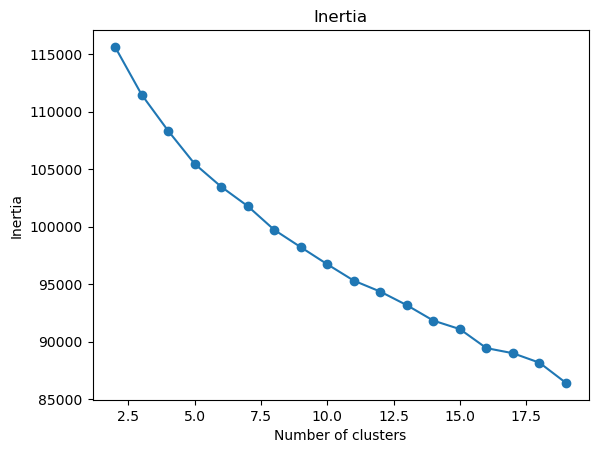

In [66]:
plt.plot(range(2, 20), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia')
plt.show()

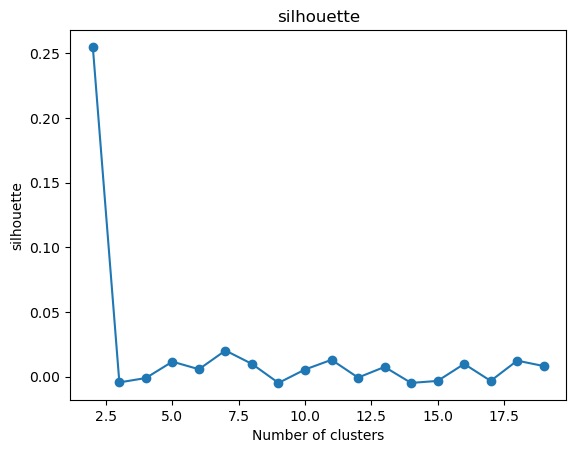

In [67]:
plt.plot(range(2, 20), silhouette, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette')
plt.title('silhouette')
plt.show()

The silhouette prefers small number of clusters 2, which is not practical in our cases. Inertia does not show clear elbow as well, so we will choose number of clusters 11 as this is the number of GICS Sectors.

In [68]:
kmeans = KMeans(n_clusters=11, n_init=200, init='k-means++', random_state=0)

In [69]:
kmeans.fit(scaled_complete_data_values)

KMeans(n_clusters=11, n_init=200, random_state=0)

In [70]:
# add the results in the data
complete_data['KmeansCluster'] = kmeans.predict(scaled_complete_data_values)

In [71]:
# check the number of stocks in each cluster
complete_data['KmeansCluster'].value_counts()

KmeansCluster
0     209
2      87
6      50
5      47
7      36
1      25
10     22
3       5
8       3
4       1
9       1
Name: count, dtype: int64

We can see that perform Kmeans directly on the dataset produces highly unbalaned results: Cluster 0 is dominant, with 209 points while Clusters 3, 8, 4 and 9 have less than 5 points each. Lets check Spearman correlation within each cluster:

In [72]:
corr_matrix = complete_data.sort_values(by='KmeansCluster').iloc[:,:num_dates].T.corr(method='spearman').values

<Axes: >

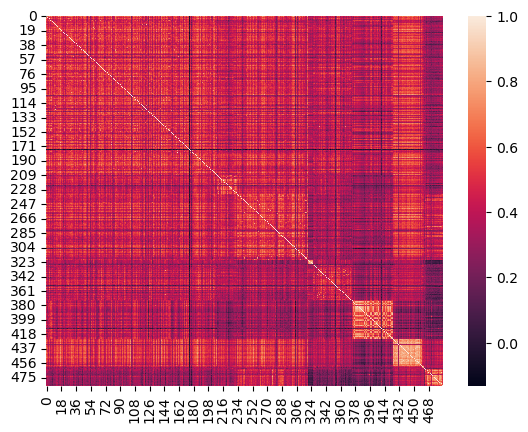

In [73]:
sns.heatmap(corr_matrix)

In [74]:
num_clusters = complete_data['KmeansCluster'].value_counts().sort_index().values
kmeans_group_corr, kmeans_score = clustering_scores(corr_matrix, num_clusters)

In [75]:
# spearman correlation within each group
kmeans_group_corr

array([0.48415708, 0.5238761 , 0.50217653, 0.81607145, 1.        ,
       0.44855909, 0.62779404, 0.7610497 , 0.84710464, 1.        ,
       0.61872464])

In [76]:
num_clusters

array([209,  25,  87,   5,   1,  47,  50,  36,   3,   1,  22])

In [77]:
# averaged
kmeans_score

np.float64(0.5351408903587269)

Recall that the baseline model using GICS Sector direclt have weighted average Spearman correlation around 0.54 and the average correlation without clustering is around 0.41.  So performing Kmeans directly on the data produces better clsutering than randomly assign a cluster to each stock, but is seems that the result could be slightly worse than baseline model. 

However, the weighted correlation may not our main concern (since 0.535 is actually very close to 0.54). We are more corcerned the unbalaned clustering results given by the model, so we analyze the results below:


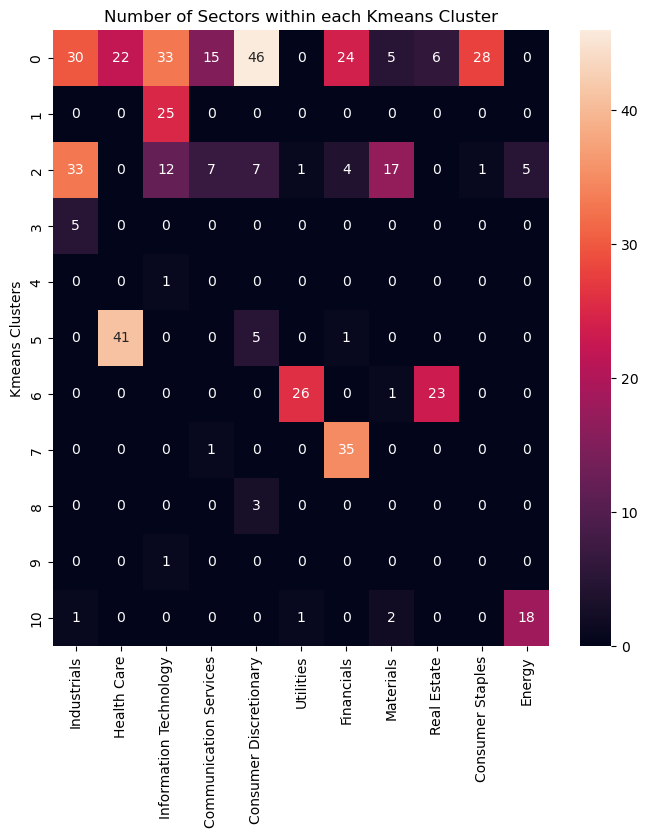

In [78]:
# check number of compaines in different GICS Sectors Within Each Kmeans Cluster
overlap = pd.DataFrame(columns=complete_data['GICS Sector'].unique())
for cluster in range(len(complete_data['KmeansCluster'].unique())):
    overlap.loc[cluster,:] = np.nan
    cluster_res = complete_data[complete_data['KmeansCluster'] == cluster]['GICS Sector'].value_counts()
    for sector in complete_data['GICS Sector'].unique():
        if sector in cluster_res.index:
            overlap.loc[cluster, sector] = cluster_res[sector]
        else:
            overlap.loc[cluster, sector] = 0
overlap.index.name = 'Kmeans Clusters'
plt.figure(figsize=(8,8))
sns.heatmap(overlap.astype('float'), annot=True)
plt.title('Number of Sectors within each Kmeans Cluster')
plt.show()

The above plot displays the number of compaines in different GICS Sectors within each Kmeans cluster. It shows that Cluster 0 are a mixture of all sectors except in Utilities, Materials, Real Estate and Energy.

In total, the clustering results using Kmeans direcly are very unbalanced: the cluster 0 include almost half (209/486) compaines, while 3,4,8,9 inclue less than 5 compaines.

2. Scale each stock and then KMeans

This method first scale the daily return according to each stock.
The rationale behind this is the scaling makes the squared euclidean distance between stocks x and y equaling to 2 - corr(x,y).

In fact, let $x = (x(1), ... x(n))^T$ and $y = (y(1), ... y(n))^T$, we then have
\begin{aligned}
\text{euclidean}(x, y)^2 &= \sum_{i=1}^n (x(i) - y(i))^2 \\
&= \sum_{i=1}^n x(i)^2 + \sum_{i=1}^n y(i)^2 - 2 \sum_{i=1}^n x(i)y(i). 
\end{aligned}
Since $x$ and $y$ are scaled so that $E(x) = E(y) = 0$ and $Var(x) = Var(y) = 1$, we have
\begin{aligned}
\text{euclidean}(x, y)^2 = 2 - 2corr(x,y)
\end{aligned}

Kmeans greedily cluster groups to minimize euclidean distance -- > maximize corrleation.

In [79]:
std_scaler = StandardScaler()
scaled_complete_data_values = std_scaler.fit_transform(complete_data_values.T)
scaled_complete_data_values = scaled_complete_data_values.T 

In [80]:
kmeans = KMeans()

In [81]:
kmeans = KMeans(n_clusters=11, n_init=200, init='k-means++', random_state=0)

In [82]:
kmeans.fit(scaled_complete_data_values)

KMeans(n_clusters=11, n_init=200, random_state=0)

In [83]:
complete_data['ScaledKmeansCluster'] = kmeans.predict(scaled_complete_data_values)

In [84]:
complete_data['ScaledKmeansCluster'].value_counts()

ScaledKmeansCluster
3     120
0      95
10     50
8      46
4      43
5      27
1      26
6      25
9      23
7      22
2       9
Name: count, dtype: int64

Compared with performing Kmeans directly, the result above is more balanced.

In [85]:
corr_matrix = complete_data.sort_values(by='ScaledKmeansCluster').iloc[:,:num_dates].T.corr(method='spearman').values

<Axes: >

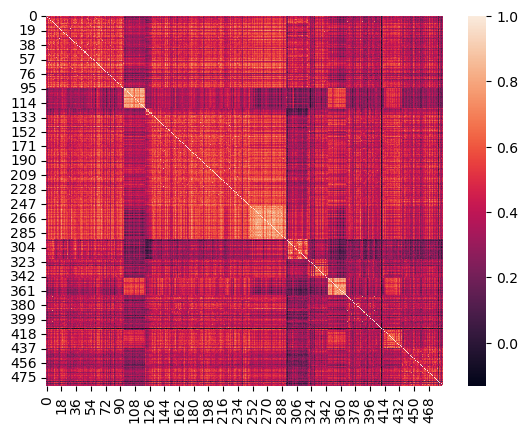

In [86]:
sns.heatmap(corr_matrix)

In [87]:
num_clusters = complete_data['ScaledKmeansCluster'].value_counts().sort_index().values
scaled_kmeans_group_corr, scaled_kmeans_score = clustering_scores(corr_matrix, num_clusters)

In [88]:
scaled_kmeans_group_corr

array([0.50985054, 0.77408635, 0.61754758, 0.53624334, 0.74797086,
       0.57859353, 0.50907413, 0.75715176, 0.36282737, 0.59916029,
       0.46319798])

In [89]:
scaled_kmeans_score

np.float64(0.554050995701923)

This method by first scaling the data across each stock and then performing Kmeans produce more balanced results than perfoming Kmeans directly.
Also, it achieves slightly higher score (0.5540) than the baseline (0.5420).

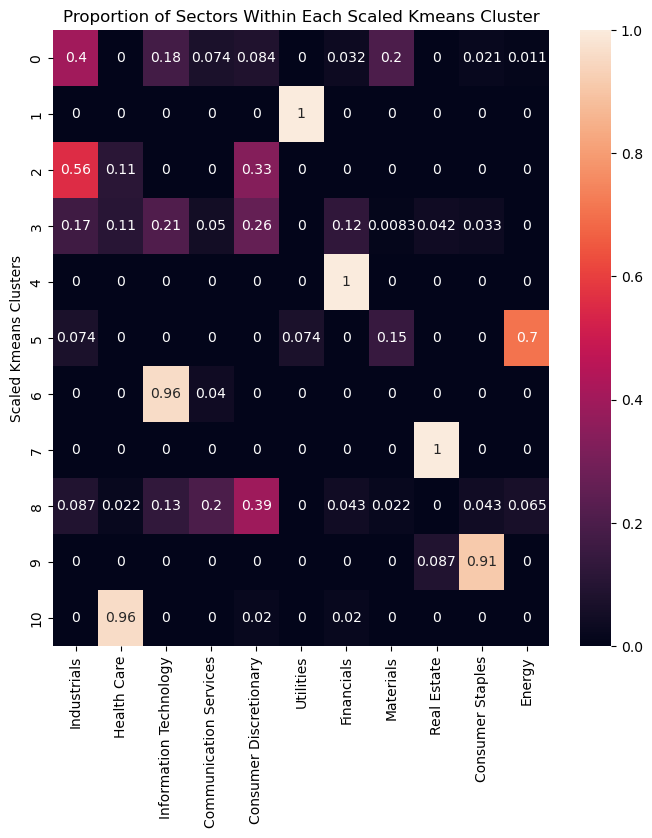

In [90]:
# analyze the proportion of compaines in different GICS Sector within each cluster
overlap = pd.DataFrame(columns=complete_data['GICS Sector'].unique())
for cluster in range(len(complete_data['ScaledKmeansCluster'].unique())):
    overlap.loc[cluster,:] = np.nan
    cluster_res = complete_data[complete_data['ScaledKmeansCluster'] == cluster]['GICS Sector'].value_counts()
    for sector in complete_data['GICS Sector'].unique():
        if sector in cluster_res.index:
            overlap.loc[cluster, sector] = cluster_res[sector]
        else:
            overlap.loc[cluster, sector] = 0
overlap.index.name = 'Scaled Kmeans Clusters'
plt.figure(figsize=(8,8))
sns.heatmap(overlap.div(overlap.sum(axis=1), axis=0).astype('float'), annot=True)
plt.title('Proportion of Sectors Within Each Scaled Kmeans Cluster')
plt.show()

The above figure shows that Kmeans clusters 1,4,5,6,7,9,10 are consist mainly one sector, while other clusters are mixed with several sectors. 

3. Scale each stock + PCA + Kmeans:

In [91]:
# reduce dimensiona through PCA
threshold = 0.8 # explain 80% variance
pca = PCA(n_components=threshold)

In [92]:
complete_data_values_PCA = pca.fit_transform(scaled_complete_data_values)

In [93]:
complete_data_values_PCA.shape

(486, 91)

In [94]:
# we are reduced to 91 dimensions from 251

In [95]:
kmeans = KMeans(n_clusters=11, n_init=200, init='k-means++', random_state=0)

In [96]:
kmeans.fit(complete_data_values_PCA)

KMeans(n_clusters=11, n_init=200, random_state=0)

In [97]:
clusters = kmeans.predict(complete_data_values_PCA)

In [98]:
complete_data['PCAKmeansCluster'] = clusters # add clustring results to complete_data

In [99]:
complete_data

2015-01-05  2015-01-06  2015-01-07  2015-01-08  2015-01-09  \
Symbol                                                               
MMM      -0.022553   -0.010663    0.007249    0.023967   -0.012283   
ABT       0.000223   -0.011356    0.008108    0.020554   -0.010508   
ABBV     -0.018819   -0.004950    0.040417    0.010459   -0.027355   
ABMD     -0.006433   -0.025357    0.031829    0.045064   -0.014117   
ACN      -0.016885   -0.007213    0.020989    0.015249   -0.001113   
...            ...         ...         ...         ...         ...   
YUM      -0.020318   -0.012274    0.033138    0.017420   -0.001767   
ZBRA     -0.014077   -0.007205    0.025465    0.021359    0.014613   
ZBH       0.037303   -0.008476    0.024870    0.010617   -0.014424   
ZION     -0.037469   -0.038193    0.009546    0.013994   -0.027975   
ZTS      -0.006003   -0.009756    0.020643    0.015399    0.001584   

        2015-01-12  2015-01-13  2015-01-14  2015-01-15  2015-01-16  ...  \
Symbol                                                              ...   
MMM      -0.005445   -0.000747   -0.004856   -0.001126    0.014656  ...   
ABT       0.008407   -0.016101   -0.007398   -0.007453    0.012287  ...   
ABBV     -0.000304   -0.028804    0.004890   -0.012716    0.026236  ...   
ABMD      0.003905    0.006483   -0.014429   -0.029804    0.021827  ...   
ACN      -0.003007    0.003575   -0.011689   -0.006871    0.008166  ...   
...            ...         ...         ...         ...         ...  ...   
YUM      -0.007487   -0.004115    0.001524   -0.011894    0.013716  ...   
ZBRA      0.001490    0.023308   -0.015871    0.000615    0.020054  ...   
ZBH       0.002369    0.002194   -0.013221   -0.018774    0.017568  ...   
ZION     -0.015349   -0.017147   -0.017050   -0.012102    0.011842  ...   
ZTS      -0.018757   -0.014049    0.005139   -0.002092    0.029809  ...   

                         GICS Sub-Industry    Headquarters Location  \
Symbol                                                                
MMM               Industrial Conglomerates      St. Paul, Minnesota   
ABT                  Health Care Equipment  North Chicago, Illinois   
ABBV                       Pharmaceuticals  North Chicago, Illinois   
ABMD                 Health Care Equipment   Danvers, Massachusetts   
ACN         IT Consulting & Other Services          Dublin, Ireland   
...                                    ...                      ...   
YUM                            Restaurants     Louisville, Kentucky   
ZBRA    Electronic Equipment & Instruments   Lincolnshire, Illinois   
ZBH                  Health Care Equipment          Warsaw, Indiana   
ZION                        Regional Banks     Salt Lake City, Utah   
ZTS                        Pharmaceuticals   Parsippany, New Jersey   

        Date first added      CIK      Founded  total return  volatility  \
Symbol                                                                     
MMM           09/08/1976    66740         1902     -0.042286    0.011659   
ABT           31/03/1964     1800         1888      0.044977    0.013748   
ABBV          31/12/2012  1551152  2013 (1888)     -0.023463    0.020054   
ABMD          31/05/2018   815094         1981      1.083235    0.039840   
ACN           06/07/2011  1467373         1989      0.215587    0.012934   
...                  ...      ...          ...           ...         ...   
YUM           06/10/1997  1041061         1997      0.086126    0.020421   
ZBRA          23/12/2019   877212         1969     -0.011748    0.026731   
ZBH           07/08/2001  1136869         1927     -0.064005    0.012888   
ZION          22/06/2001   109380         1873      0.010224    0.017499   
ZTS           21/06/2013  1555280         1952      0.151947    0.018626   

        KmeansCluster  ScaledKmeansCluster  PCAKmeansCluster  
Symbol                                                        
MMM                 0                    3                 5  
ABT                

In [100]:
# compute correlation matrix
corr_matrix = complete_data.sort_values(by='PCAKmeansCluster').iloc[:,:num_dates].T.corr(method='spearman').values

<Axes: >

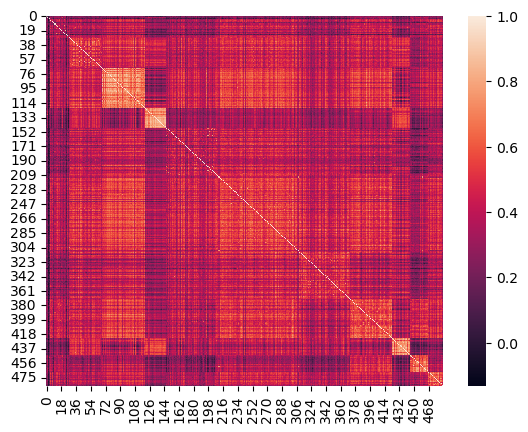

In [101]:
sns.heatmap(corr_matrix)

In [102]:
num_clusters = complete_data['PCAKmeansCluster'].value_counts().sort_index().values
pca_kmeans_group_corr, pca_kmeans_score = clustering_scores(corr_matrix, num_clusters)

In [103]:
# correlation within each cluster
print(pca_kmeans_group_corr)

[0.33570987 0.52834635 0.71727884 0.77408635 0.42265234 0.52874564
 0.47714681 0.57566622 0.74167078 0.64681884 0.61403879]


In [104]:
print(num_clusters)

[ 29  39  53  26  60 105  60  51  23  22  18]


In [105]:
# weighted average correlation
print(pca_kmeans_score)

0.5549166182794194


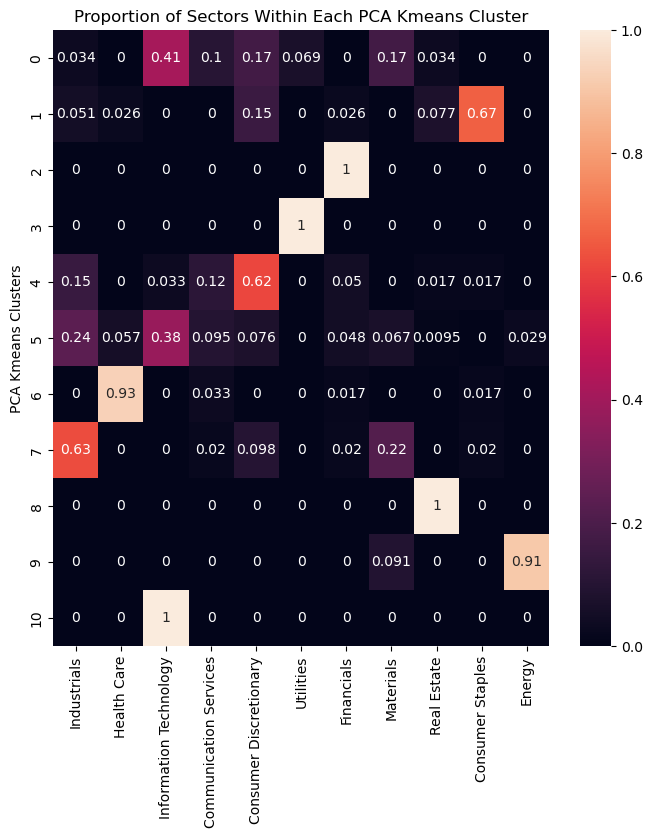

In [106]:
# analyze the proportion of compaines in different GICS Sector within each cluster
overlap = pd.DataFrame(columns=complete_data['GICS Sector'].unique())
for cluster in range(len(complete_data['PCAKmeansCluster'].unique())):
    overlap.loc[cluster,:] = np.nan
    cluster_res = complete_data[complete_data['PCAKmeansCluster'] == cluster]['GICS Sector'].value_counts()
    for sector in complete_data['GICS Sector'].unique():
        if sector in cluster_res.index:
            overlap.loc[cluster, sector] = cluster_res[sector]
        else:
            overlap.loc[cluster, sector] = 0
overlap.index.name = 'PCA Kmeans Clusters'
plt.figure(figsize=(8,8))
sns.heatmap(overlap.div(overlap.sum(axis=1), axis=0).astype('float'), annot=True)
plt.title('Proportion of Sectors Within Each PCA Kmeans Cluster')
plt.show()

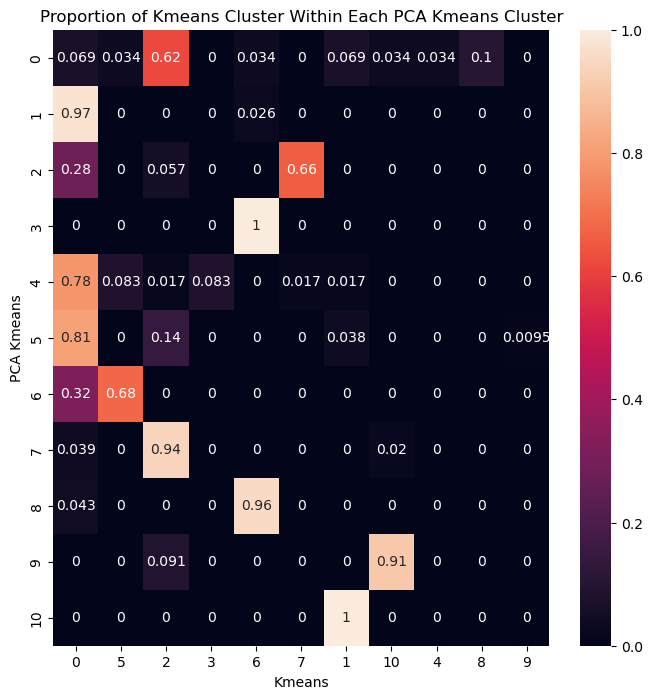

In [107]:
# analyze the proportion of compaines in different GICS Sector within each clusterx
pca_overlap = pd.DataFrame(columns=complete_data['KmeansCluster'].unique())
for cluster in range(len(complete_data['PCAKmeansCluster'].unique())):
    pca_overlap.loc[cluster,:] = np.nan
    cluster_res = complete_data[complete_data['PCAKmeansCluster'] == cluster]['KmeansCluster'].value_counts()
    for sector in complete_data['KmeansCluster'].unique():
        if sector in cluster_res.index:
            pca_overlap.loc[cluster, sector] = cluster_res[sector]
        else:
            pca_overlap.loc[cluster, sector] = 0
plt.figure(figsize=(8,8))
sns.heatmap(pca_overlap.div(pca_overlap.sum(axis=1), axis=0).astype('float'), annot=True)
plt.title('Proportion of Kmeans Cluster Within Each PCA Kmeans Cluster')
plt.xlabel('Kmeans')
plt.ylabel('PCA Kmeans')
plt.show()

The average weighted score of Scaled Kmeans method and PCA Kmeans method are very similar: 0.5540 vs 0.5549. However, by analyzing the overlaping rate between the clusters of the two methods, we can see that the clustering results given by the two methods are different: while Clusters 2, 3, 6, 7, 8, 9, 10 given by PCA Kmeans corresponding mainly to Clusters 4, 1, 10, 0, 7, 5, 6 given be Scaled Kmeans method, other Clusters given by PCA Kmeans are mixed of different Clusters given by Scaled Kmeans method.

It is hard to decide which method has better performances by our evaluion method based on correlation. A more reasonable thing to do would be to develop cluster-based trading stragety and evalute which cluster results give higher return.

# Conclusion

In this project, we cluster 486 stocks using only their daily returns in 2015. As a baseline for evaluating the quality of our clustering results, we compare them to a grouping of stocks based directly on their GICS Sectors.

We explore three K-means-based methods:

1. Vanilla K-means: Applies K-means directly to the data after scalling data according to each column.
2. Scaled K-means: First scales the returns of each stock individually (e.g., standardizing across time), then applies K-means to the scaled data.
3. PCA K-means: Also scales each stock’s returns individually, but then performs PCA before applying K-means.

The results given by the first method are not ideal: it produces highly unbalanced clusters, with the largest cluster containing almost half of the stocks, while four clusters contain less than 5 stocks. Its weighted average Spearman correlation is also lower than the baseline.

The second and third methods yield more balanced clusters, and both achieve slightly higher weighted average Spearman correlations compared to the baseline. Interestingly, although their correlation scores are similar, an analysis of overlapping proportions reveals that they produce notably different clustering results.

It is difficult to conclude whether the second or third method is superior based on correlation metrics alone. A more meaningful evaluation could involve developing cluster-based trading strategies and comparing the financial performance of portfolios constructed from each method.

To further improve the clustering, one promising direction is to denoise the data before applying K-means. While we use PCA in the third method as a basic denoising step, additional techniques such as outlier removal or smoothing returns using an exponential moving average could be explored.

Another important point to note is that the correlation matrix computed in this project is singular, as the number of stocks exceeds the number of trading days. This can lead to unstable or inaccurate correlation estimates. To address this issue, one possible improvement is to collect more data points (i.e., extend the time period). Alternatively, we could use more robust estimation techniques, such as regularized or shrinkage-based correlation matrices, to obtain more reliable results.